<a href="https://colab.research.google.com/github/akash-agni/Machine_Learning/blob/master/Santender_Bank_Transaction_Prediction_Using_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using LightGBM to Solve Kaggles Santander Customer Transaction Prediction Challenge From Colab.

### Setting Up Kaggle API in Colab

1. Get your  kaggle API Token.
    1. Go to your kaggle Home Page and click on the image in top right.
    2. Select Account from list.
    3. Go to API Section and select Expire API.
    4. Click on Create New API which downloads the Kaggle.json file.

2. Upload the json file into colab notebook.
    1. Select file option from right bar options.
    2. Select upload file and upload kaggle json.

3. Create directory for kaggle. 
    ! mkdir ~/.kaggle

4. Install Kaggle Library
    ! pip install -q kaggle

5. Copy kaggle.json to kaggle folder
    ! cp kaggle.json ~/.kaggle

6. Change permission for json file to be executionable
    ! chmod 600 ~/.kaggle/kaggle.json
    
7. Run API Command to get competitions files
    ! kaggle competitions download -c santander-customer-transaction-prediction

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
! kaggle competitions download -c santander-customer-transaction-prediction

 98% 122M/125M [00:00<00:00, 187MB/s] 
100% 125M/125M [00:00<00:00, 231MB/s]
  0% 0.00/462k [00:00<?, ?B/s]
100% 462k/462k [00:00<00:00, 155MB/s]
 89% 111M/125M [00:00<00:00, 151MB/s] 
100% 125M/125M [00:00<00:00, 212MB/s]


In [3]:
! unzip train.csv.zip
! unzip test.csv.zip
! unzip sample_submission.csv.zip
! rm -rf train.csv.zip test.csv.zip sample_submission.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [4]:
# After running
! git clone --recursive https://github.com/Microsoft/LightGBM

#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;

Cloning into 'LightGBM'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 21264 (delta 24), reused 1 (delta 0), pack-reused 21218
Receiving objects: 100% (21264/21264), 16.68 MiB | 30.19 MiB/s, done.
Resolving deltas: 100% (15577/15577), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728      

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
#! pip install -U imbalanced-learn
#import imblearn
import lightgbm as lgb

In [6]:
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [9]:
df = pd.read_csv('train.csv')
print(f'Shape of Training Data is : {df.shape[0]} rows and {df.shape[1]} columns')
df.sample(3)

Shape of Training Data is : 200000 rows and 202 columns


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
72770,train_72770,1,9.1131,4.7830,8.6771,6.4193,11.6221,-21.3532,5.7915,22.7902,3.1438,7.2629,-3.3504,7.8759,13.9751,2.9007,7.9522,14.5470,5.7019,-4.3332,21.8533,17.1694,14.1612,9.5043,5.6870,2.0530,8.9329,13.4215,-8.2310,-3.3703,5.4711,6.0639,9.9043,7.4320,-0.5861,20.1745,11.0434,1.4971,2.4919,3.9566,...,18.6303,5.5905,8.0836,12.0534,-1.7134,27.4819,2.4859,5.8760,-1.2425,5.2076,3.6145,1.5723,19.5087,8.1547,21.7852,14.1920,3.7504,6.7356,4.5426,4.5728,-3.2520,10.6763,8.1382,6.1715,3.3318,-6.9972,5.9533,-28.2719,7.5283,0.5022,7.8339,3.9116,1.7304,1.1314,19.9238,-2.7959,9.1279,9.0038,14.1883,-22.7476
116215,train_116215,0,12.6031,-0.0079,7.9795,6.7950,13.4213,-13.6361,3.9097,12.1833,4.2239,8.5616,-2.1658,-13.5333,13.7859,2.1489,4.9659,14.9405,8.4194,-7.2231,4.0174,12.3439,7.6491,17.4168,3.6851,2.8948,4.8579,13.2146,-8.1885,-2.8118,4.9233,6.7837,4.5547,6.9943,0.9892,12.1417,11.5904,2.3081,2.2066,1.7418,...,23.4221,5.2982,7.9865,8.0627,-0.7228,15.5515,3.6152,-6.1895,4.7111,5.4834,4.0407,4.1797,16.8010,1.4421,6.2587,10.8484,-5.9934,15.6594,-1.6178,1.7290,2.7652,10.5912,-1.6086,7.7187,-0.9298,6.3304,14.0870,-30.0679,15.2072,0.3970,4.3421,8.3897,1.4871,-1.3986,14.0780,-1.9388,3.8953,10.6144,16.0924,20.7105
118561,train_118561,0,11.4269,4.9149,14.7455,5.6882,11.8976,-4.2012,6.1780,20.7242,0.9946,9.7886,3.4936,3.0854,13.8707,-0.0135,12.0040,14.3754,10.8677,-13.3102,23.5523,5.7228,12.2680,14.4578,6.7529,3.3322,6.0151,13.4644,0.6880,0.9394,5.6790,4.5834,1.0563,14.6313,-2.3430,10.6450,12.5559,2.8601,5.8703,8.4621,...,16.3661,5.3596,4.8795,6.8406,5.0819,21.1695,3.6290,-13.0896,3.6670,6.1623,6.7088,-3.5380,17.1409,1.6089,17.7123,10.5060,-7.7631,15.0907,-12.4969,9.3213,-6.2063,9.4614,6.3960,13.5323,17.7469,1.8382,5.3562,1.2091,10.4555,0.8069,8.6035,13.4227,4.5479,9.7603,19.7257,-0.5667,-2.0744,10.1010,9.7868,11.3131


In [10]:
mean = list()
std = list()
skewness = list()
kurt = list()
for var in df.drop(['ID_code', 'target'], axis=1).columns:
  mean.append(np.mean(df[var]))
  std.append(np.std(df[var]))
  skewness.append(skew(df[var]))
  kurt.append(kurtosis(df[var]))

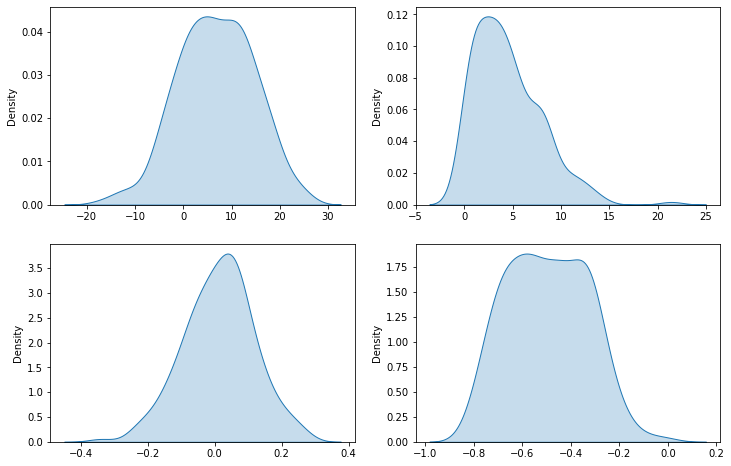

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
fig = sns.kdeplot(mean, ax=ax[0][0], shade=True, label="Distribution of Mean")
fig = sns.kdeplot(std, ax=ax[0][1], shade=True, label="Distribution of Standard Variance")
fig = sns.kdeplot(skewness, ax=ax[1][0],shade=True, label="Distribution of Skewness")
fig = sns.kdeplot(kurt, ax=ax[1][1],shade=True, label="Distribution of Kurtosis")

In [12]:
df['mean'] = np.mean(df.drop(['ID_code','target'], axis=1), axis=1)
df['median'] = np.median(df.drop(['ID_code','target'], axis=1), axis=1)
df['max'] = np.max(df.drop(['ID_code','target'], axis=1), axis=1)
df['min'] = np.min(df.drop(['ID_code','target'], axis=1), axis=1)
df['std'] = np.std(df.drop(['ID_code','target'], axis=1), axis=1)
df['skewness'] = skew(df.drop(['ID_code','target'], axis=1), axis=1)
df['kurtosis'] = kurtosis(df.drop(['ID_code','target'], axis=1), axis=1)

In [13]:
for col in df.drop(['ID_code','target','mean','median','max','min','std','skewness','kurtosis'], axis=1).columns:
  df[f'{col}_uni'] = df[col].duplicated()*1

In [14]:
df.iloc[:,202:208].head()

,mean,median,max,min,std,skewness
0,7.281591,6.7806,43.1127,-21.4494,9.761325,0.190000
1,7.076818,7.1051,40.5632,-47.3797,11.146304,-0.688164
2,6.204483,5.9525,33.8820,-22.4038,9.083563,-0.066380
3,6.441159,6.5850,38.1015,-35.1659,10.158122,-0.570874
4,6.771155,6.9087,41.1037,-65.4863,12.474544,-1.860747


In [15]:
#corr_mat = df.drop(['ID_code'], axis=1).corr()
#fig, ax = plt.subplots(figsize=(14,10))
#sns.heatmap(corr_mat)

In [16]:
#corr_mat['target'].sort_values(ascending=False).head(10)

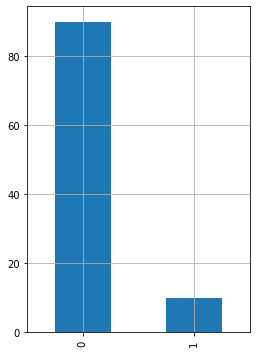

In [17]:
fig, ax = plt.subplots(figsize=(4,6))
(df['target'].value_counts()/len(df)*100).plot.bar(ax)
plt.grid()

In [18]:
df_train, df_test = train_test_split(df.drop('ID_code', axis=1))
df_val, df_test = train_test_split(df_test, test_size=0.4)
print(f"Shape of Training Data : {df_train.shape[0]} rows")
print(f"Shape of Validation Data : {df_val.shape[0]} rows")
print(f"Shape of Testing Data : {df_test.shape[0]} rows")

Shape of Training Data : 150000 rows
Shape of Validation Data : 30000 rows
Shape of Testing Data : 20000 rows


In [19]:
X_train, X_val, X_test= df_train.drop('target', axis=1), df_val.drop('target', axis=1), df_test.drop('target', axis=1)
y_train, y_val, y_test = df_train['target'], df_val['target'], df_test['target']

In [25]:
#smote = imblearn.over_sampling.SMOTE(sampling_strategy=0.3)
#under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy=0.7)

#X_train, y_train = smote.fit_resample(X_train, y_train)
#X_train, y_train = under.fit_resample(X_train, y_train)

In [26]:
#s_scaler = StandardScaler()
#s_scaler.fit(X_train)
#X_train = s_scaler.transform(X_train)
#X_val = s_scaler.transform(X_val)
#X_test = s_scaler.transform(X_test)

In [27]:
trn_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

In [29]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1,
    'device': 'gpu'
}

In [30]:
clf = lgb.train(param, trn_data, num_boost_round=1000000, valid_sets=[trn_data, val_data], verbose_eval=1000,
                early_stopping_rounds=3000)

[LightGBM] [Info] Number of positive: 15056, number of negative: 134944
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 53185
[LightGBM] [Info] Number of data points in the train set: 150000, number of used features: 407
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 284 dense feature groups (40.63 MB) transferred to GPU in 0.059133 secs. 1 sparse feature groups
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.890274	valid_1's auc: 0.877043
[2000]	training's auc: 0.908721	valid_1's auc: 0.891003
[3000]	training's auc: 0.919826	valid_1's auc: 0.89799
[4000]	training's auc: 0.927644	valid_1's auc: 0.901563
[5000]	training's auc: 0.933851	valid_1's auc: 0.903328
[6000]	training's auc: 0.938992	valid_1's auc: 0.904225
[7000]	traini

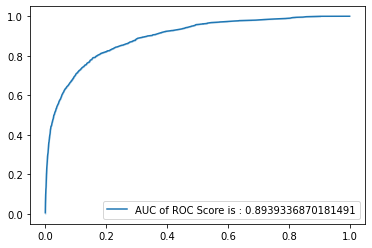

In [31]:
y_pred = clf.predict(X_test, num_iteration=clf.best_iteration)
roc_score = metrics.roc_auc_score(y_test, y_pred)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,4))
sns.lineplot(x=fpr, y=tpr, label=f"AUC of ROC Score is : {roc_score}")

In [32]:
gmeans = np.sqrt(tpr*(1-fpr))
thres = threshold[np.argmax(gmeans)]
print(f"Threshold to Use : {thres}")

Threshold to Use : 0.10903162201111738


In [44]:
df_sub = pd.read_csv('test.csv')
df_sub['mean'] = np.mean(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['median'] = np.median(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['max'] = np.max(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['min'] = np.min(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['std'] = np.std(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['skewness'] = skew(df_sub.drop(['ID_code'], axis=1), axis=1)
df_sub['kurtosis'] = kurtosis(df_sub.drop(['ID_code'], axis=1), axis=1)
for col in df_sub.drop(['ID_code','mean','median','max','min','std','skewness','kurtosis'], axis=1).columns:
  df_sub[f"{col}_uni"] = df_sub[col].duplicated()*1
X_sub = df_sub.drop(['ID_code'], axis=1)
#X_sub = s_scaler.transform(X_sub)

In [46]:
y_sub = pd.DataFrame(df_sub['ID_code'].copy())
y_sub['target'] = clf.predict(X_sub, num_iteration=clf.best_iteration)
#y_sub['target'] = (y_sub['target'] >= thres)*1
y_sub.head()

,ID_code,target
0,test_0,0.094701
1,test_1,0.222756
2,test_2,0.180797
3,test_3,0.176377
4,test_4,0.040723


In [47]:
y_sub.to_csv('Submission.csv', index=False)

In [48]:
! kaggle competitions submit -c santander-customer-transaction-prediction -f Submission.csv -m "First Attempt"

100% 6.06M/6.06M [00:00<00:00, 11.2MB/s]
Successfully submitted to Santander Customer Transaction Prediction